### ANALYTIC SOLUTION FOR SCALAR WAVE 2D FREE SPACE 

Based on Alford 1974 Geophysics. 
"ACCURACY OF FINITE-DIFFERENCE MODELING OF THE ACOUSTIC WAVE EQUATION"

Using cylindrical coordinates for a free a space medium homogeneous of velocity **$v$**. If the observer is at a **$\rho$** distance from the source. The analytical solution is written from the frequency domain solution as:

$$
U(\rho, t) = \frac{1}{2\pi}\int_{-\inf}^{+\inf}-F(\omega) i\pi H^{(2)}_{0}(k\rho)
$$

where $F(\omega)$ is the fourier transform of the source
function $f(t)$

$H^{(2)}$ is the second Hankel function of order 0

and $k = \omega/v $

To avoid and diminish numerical errors we can use a source with analytical fourier transform known 

For simplicity on above equation we can use a simple Gauss Pulse:

$$ f(t) = te^{-\alpha t^2} $$ 

and its Fourier Transform $F(\omega)$ (note: in Alford's paper it was a bit different, I trust this one from Wolfram)

$$ F(\omega) = \frac{i\omega}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)}
$$

So simplifying the first one we get:

$$ U(\rho, t) = -i\pi H^{(2)}_{0}(k\rho_s)  \frac{i\omega}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)} $$

$$ U(\rho, t) =  H^{(2)}_{0}(k\rho_s)  \frac{\omega\pi}{2\sqrt{2} \alpha^{\frac{3}{2}}}e^{-\left(\frac{\omega^2}{4\alpha}\right)} $$

### Using partially analytical solution in frequency domain Ricker Wavelet ###


The wavelet is created in time then fourier transformed to frequency to apply<br/> 
the analytical solution and then apply back the inverse fourier transform to get it back to time

It's recommended to use the partially time / partially frequency analytical solution implementation.

Then you are able to compare and check how reliable is your F.D. using the error curve. 

In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib.animation
import matplotlib
import numpy as np
from numba import njit, prange

In [13]:
def wave2d_analytic(rho, c, dt, source):
    """
    Analytic solution wave equation 2D for free space.
    Assume that source is at rho=0
    Do not evaluate at zero, solution not real!
    * rho : float
        distance to the source function
    * c : float
        velocity
    * dt : float
        sample rate for time source and analytical solution
    * source : 1D array
        source function in time
    References:
    Alford, R. M., Kelly, K. R., Boore, D. M. (1974) Accuracy of
    finite-difference modeling of the acoustic wave equation.
    Geophysics, 39(06), 834-842
    """
    n = source.size
    if rho/c > dt*n:  # make enough time for final solution
        newn = (rho/c)/dt + 16
        source = signal.resample(source, newn)
        n = newn
    # omega (2pi*f) increment for each omega that will be sampled
    ws = numpy.pi*2*numpy.arange(0, (1./dt), (1./dt)/n)
    # all k's = w/c in omega/frequency domain to evaluate the solution
    ks = ws/c
    # hankel filter kernel
    hankel = -1j*numpy.pi*hankel2(0, ks*rho)
    hankel[0] = 1j  # i infinity in limit
    sw = numpy.fft.fft(source)  # just go to frequency
    return numpy.real(numpy.fft.ifft(hankel*sw))


def wedge_cylindrical(rho, phi, rho_s, phi_s, c, source, dt):
    """
    Analytic solution equation (3) paper Alford et. al. cylindrical coordinates
    for \rho (observation point) smaller equal \rho_s (source point)
    (look figure 1. in paper)
    90 degrees wedge model cylindrical coordinates
    
    R.M. Alford - Accuracy of Finite-Difference Modeling
    rho - radius from center position of observation point
    phi - angle in radians position of observation point
    rho_s - radius from center position of source function
    phi_s - angle in radians position of source function
    c - velocity    
    source - source fuction sampled in time
    dt - sample rate from source function in time
    """
    N = len(source)
    dw = numpy.pi*2*(1./dt)/N # omega increment for each omega that will be sampled 
    ks = numpy.array([(p*dw/c) for p in xrange(N)]) # all k's = w/c in omega/frequency domain to evaluate the solution
    
    # serie aproximation just 100 first terms
    serie = numpy.zeros(N) +1j * numpy.zeros(N)
    for n in xrange(1,100):
        tmp = jn(2*n/3, ks*rho)*hankel2(2*n/3,ks*rho_s)*numpy.sin(2*n*phi_s/3)*numpy.sin(2*n*phi/3)
        tmp[0] = 0. # bessel and hankel undefined in 0
        serie += tmp    
    
    sourcew = numpy.fft.fft(source) # source in the frequency domain    
    return numpy.real(numpy.fft.ifft(numpy.complex(0, -8*numpy.pi/3) * sourcew * serie))

In [4]:
@njit(parallel=True)
def stepScalar(u_tp1, u_t, u_tm1, c, x1, x2, z1, z2, dx, dz, dt):
    """
    Perform a single time step in the Finite Difference solution for scalar
    waves 4th order in space
    """    
    cdz = (dt/dz)**2
    cdx = (dt/dx)**2

    for i in prange(z1, z2):
        for j in prange(x1, x2):
            u_tp1[i,j] = (2.*u_t[i,j] - u_tm1[i,j]
                + (c[i,j]**2)*(
                    cdx*(-u_t[i,j + 2] + 16.*u_t[i,j + 1] - 30.*u_t[i,j] +
                    16.*u_t[i,j - 1] - u_t[i,j - 2])/12. +
                    cdz*(-u_t[i + 2,j] + 16.*u_t[i + 1,j] - 30.*u_t[i,j] +
                    16.*u_t[i - 1,j] - u_t[i - 2,j])/12.))    
            
@njit(parallel=True)
def nonreflexive2nd(u_tp1, u_t, u_tm1, c, nx, nz, dx, dz, dt):
    """
    Apply the boundary conditions: free-surface at top, transparent in the borders
    4th order (+2-2) indexes
    Uses Reynolds, A. C. - Boundary conditions for numerical solution of wave propagation problems
    Geophysics p 1099-1110 - 1978
    We apply 1D reynolds at -2/-1 and +2/+1 respectively
    """
    for i in range(nz):
        # left
        for p in range(2):
                u_tp1[i, p] = ( u_t[i, p] + u_t[i, p+1] - u_tm1[i,p+1] +
                (c[i, p]*dt/dx)*(u_t[i, p+1] - u_t[i, p] - u_tm1[i, p+2] + u_tm1[i, p+1])
                )
        #right
        for p in range(2):
            p = 1-p            
            u_tp1[i, nx-2+p] = ( u_t[i, nx-2+p] + u_t[i, nx-3+p] - u_tm1[i, nx-3+p] -
                (c[i, nx-2+p]*dt/dx)*(u_t[i, nx-2+p] - u_t[i, nx-3+p] - u_tm1[i, nx-3+p] + u_tm1[i, nx-4+p])
                )
    # Down
    for i in range(nx):
        for p in range(2):
            p = 1-p
            u_tp1[nz-2+p, i] = ( u_t[nz-2+p, i] + u_t[nz-3+p, i] - u_tm1[nz-3+p, i] -
                    (c[nz-2+p, i]*dt/dz)*(u_t[nz-2+p, i] - u_t[nz-3+p, i] - u_tm1[nz-3+p, i] + u_tm1[nz-4+p, i])
                    )
        # Up
        for p in range(2):            
            u_tp1[p, i] = ( u_t[p, i] + u_t[p+1, i] - u_tm1[p+1, i] +
                    (c[p, i]*dt/dz)*(u_t[p+1, i] - u_t[p, i] - u_tm1[p+2, i] + u_tm1[p+1, i])
                    )
            
@njit(parallel=True)
def applyDamping(array, nx, nz, pad, decay):
    """
    Apply a decay factor to the values of the array in the padding region.
    """
    # Damping on the left
    for i in prange(nz):
        for j in range(pad):
            array[i,j] *= np.exp(-((decay*(pad - j))**2))
    # Damping on the right
    for i in prange(nz):
        for j in range(nx - pad, nx):
            array[i,j] *= np.exp(-((decay*(j - nx + pad))**2))
    # Damping on the bottom
    for i in prange(nz - pad, nz): # down
        for j in range(nx):
            array[i,j] *= np.exp(-((decay*(i - nz + pad))**2))
    # Damping up
    for i in prange(pad): # down
        for j in range(nx): # left-right
            array[i,j] *= np.exp(-((decay*(pad - i))**2))

In [5]:
@njit
def ricker(t, td, f):
    """amplitude unitária"""
    t = (t - td)
    aux = (1 - 2*(np.pi*f*t)**2)
    return aux*np.exp(-(np.pi*f*t)**2)

def params(fcut, c):
    """
    A partir da frequencia máxima na fonte `fcut` e do 
    campo de velocidades `c` calcula:
    ds, f central, t delay, dt time step
    """    
    # fcut máxima frequência na fonte
    f = 2*fcut/(3*np.sqrt(np.pi)) # f central
    td = 2*np.sqrt(np.pi)/fcut # time delay    
    lmin = np.min(c)/fcut # lambda min
    ds = lmin/5. # espaçamento grid evitar alias espacial "na lata"
    dt = (1-1e-4)*ds*np.sqrt(3)/(np.sqrt(8)*np.max(c))  # "quaaase" no limite (menor erro)
    return ds, f, td, dt


In [6]:
@njit
def runSimulation(params):
    ds, dt, c, nx, nz, nt, npad, sz, sx, td, f = params
    p = np.zeros((2, nz, nx)) # n e n+1 ou n-1
    snaps = np.zeros((nt, nz, nx))
    for i in range(nt):
        # para evitar um painel a mais : pilha de paineis 
        t, tm1 = i%2, (i+1)%2
        tp1 = tm1  

        nonreflexive2nd(p[tp1], p[t], p[tm1], c, nx, nz, ds, ds, dt)
        stepScalar(p[tp1], p[t], p[tm1], c, 2, nx-2, 2, nz-2, ds, ds, dt)

        applyDamping(p[tm1], nx, nz, npad, 0.004)
        applyDamping(p[t], nx, nz, npad, 0.004)  
        
        p[tp1, sz, sx] -= ((c[sz, sx]*dt)**2)*ricker(i*dt, td, f)  
        # simulation snapshots array            
        snaps[i, :] = p[t]    
    return snaps

In [7]:
# Set the parameters of the finite difference grid
vshape = (200, 200)
ds = 12.5 # spacing
area = [0, vshape[0]*ds, 0, vshape[1]*ds]
# Set the parameters of the finite difference grid
velocity = np.ones(vshape)*200
velocity[100:,100:] = 0.

npad = 40 # abs region
# padd velocity model with border values
padvelocity = np.pad(velocity, [npad+2*2, npad+2*2],  mode='edge')
nz, nx = padvelocity.shape

# Alford adapted by André
xs, zs = 140, 80 # source

# receivers
xa, za = 110, 90 # A - delta 7 - epsilon 2
xb, zb = 80, 80 # mirrored source positon to left
xc, zc = 80, 90 # difraction
receivers = [ [za, xa], [zb, xb], [zc, xc] ]
offset = np.array([npad+2, npad+2]) # index offset due abs borders
receivers = np.array(receivers)+offset
source = np.array([zs, xs]) + offset

# simulation params
ds, f, td, dt = params(30., np.ones(1)*200.)
maxt = 3.000
nt = int(maxt/dt)
        
print('Ds (m): {:4<.1f} f.center (Hz): {:<4.1f} ' \
      'delay (ms) : {:<4.1f}  dt (ms): {:<4.1f}  nt: {:<4d}'.format(
                    ds, f, td*1000, dt*1000, nt))

Ds (m): 1.3 f.center (Hz): 11.3 delay (ms) : 118.2  dt (ms): 4.1   nt: 734 


### Run simulation using Alford's  layout

In [8]:
snaps = runSimulation((ds, dt, padvelocity, nx, nz, nt, npad, source[0], source[1], td, f))

### Source and Receivers Layout

- star - source
- triangle - receiver

### One simulation Snap-shot

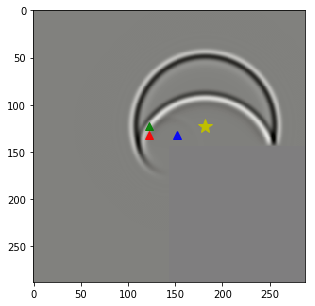

In [9]:
vmin_ = np.percentile(snaps[45, :], 99.9)
plt.figure(figsize=(5,5))
plt.imshow(padvelocity, aspect='auto')
plt.imshow(snaps[150, :], cmap='gray', alpha=0.99, vmin=-vmin_, vmax=vmin_)
plt.plot(receivers[0,1], receivers[0,0], 'b^', markersize=8, alpha=.9)
plt.plot(receivers[1,1], receivers[1,0], 'g^', markersize=8, alpha=.9)
plt.plot(receivers[2,1], receivers[2,0], 'r^', markersize=8, alpha=.9)
plt.plot(source[1], source[0], '*y', markersize=15) 
#plt.xlim((npad+2+85, 115+npad+2));
#plt.ylim((115+npad+2, npad+2+85));

### Get source used in simulation

In [10]:
t_ricker = ricker(np.arange(nt)*dt, td, f)  

### Calculate source-receiver distances 

In [11]:
distances = np.sqrt(np.sum((receivers-source)**2, axis=1))

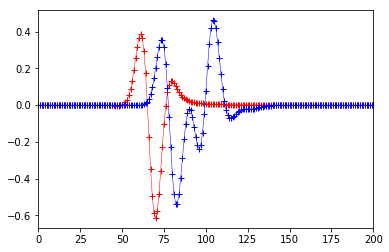

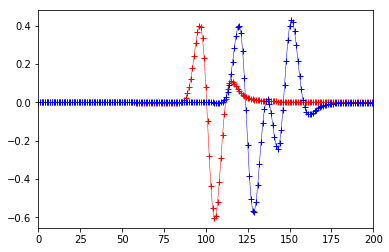

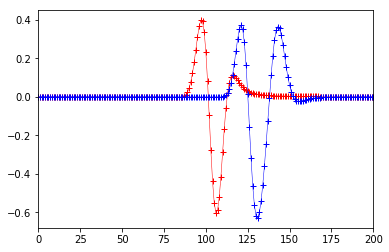

<Figure size 432x288 with 0 Axes>

In [12]:
for i, receiver in enumerate(receivers):
    distance = distances[i]
    analytic = wave2d_analytic(distance, 200, dt, t_ricker)
    real = snaps[:, receiver[0], receiver[1]]
    real = (real-np.min(real))/(np.max(real)-np.min(real))
    analytic = (analytic-np.min(analytic))/(np.max(analytic)-np.min(analytic))
    real -= np.mean(real)
    analytic -= np.mean(analytic)
    plt.plot(analytic, '-+r', lw=0.5)
    plt.plot(real, '-+b', lw=0.5)
    plt.xlim(0, 200)
    plt.figure()